## Dataset Description
This dataset consists of about 40000 articles consisting of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake.The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles each.

## Libraries and Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Exploring Fake News

In [43]:
fake = pd.read_csv('Fake.csv')
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [44]:
#Counting by Subjects 
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


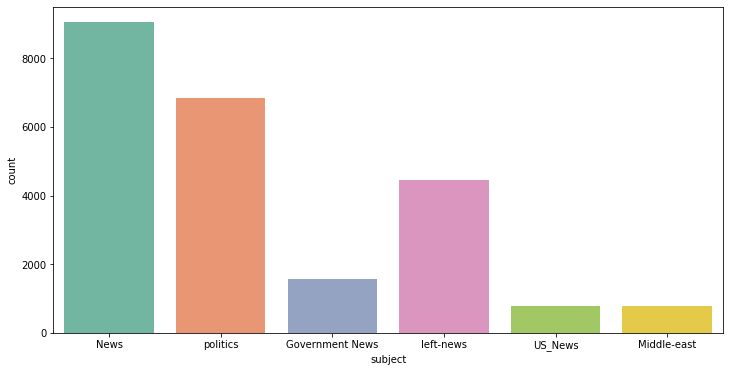

In [45]:
# visulize data above
plt.figure(figsize=(12,6))
sns.countplot("subject", data=fake, palette="Set2")
plt.show()

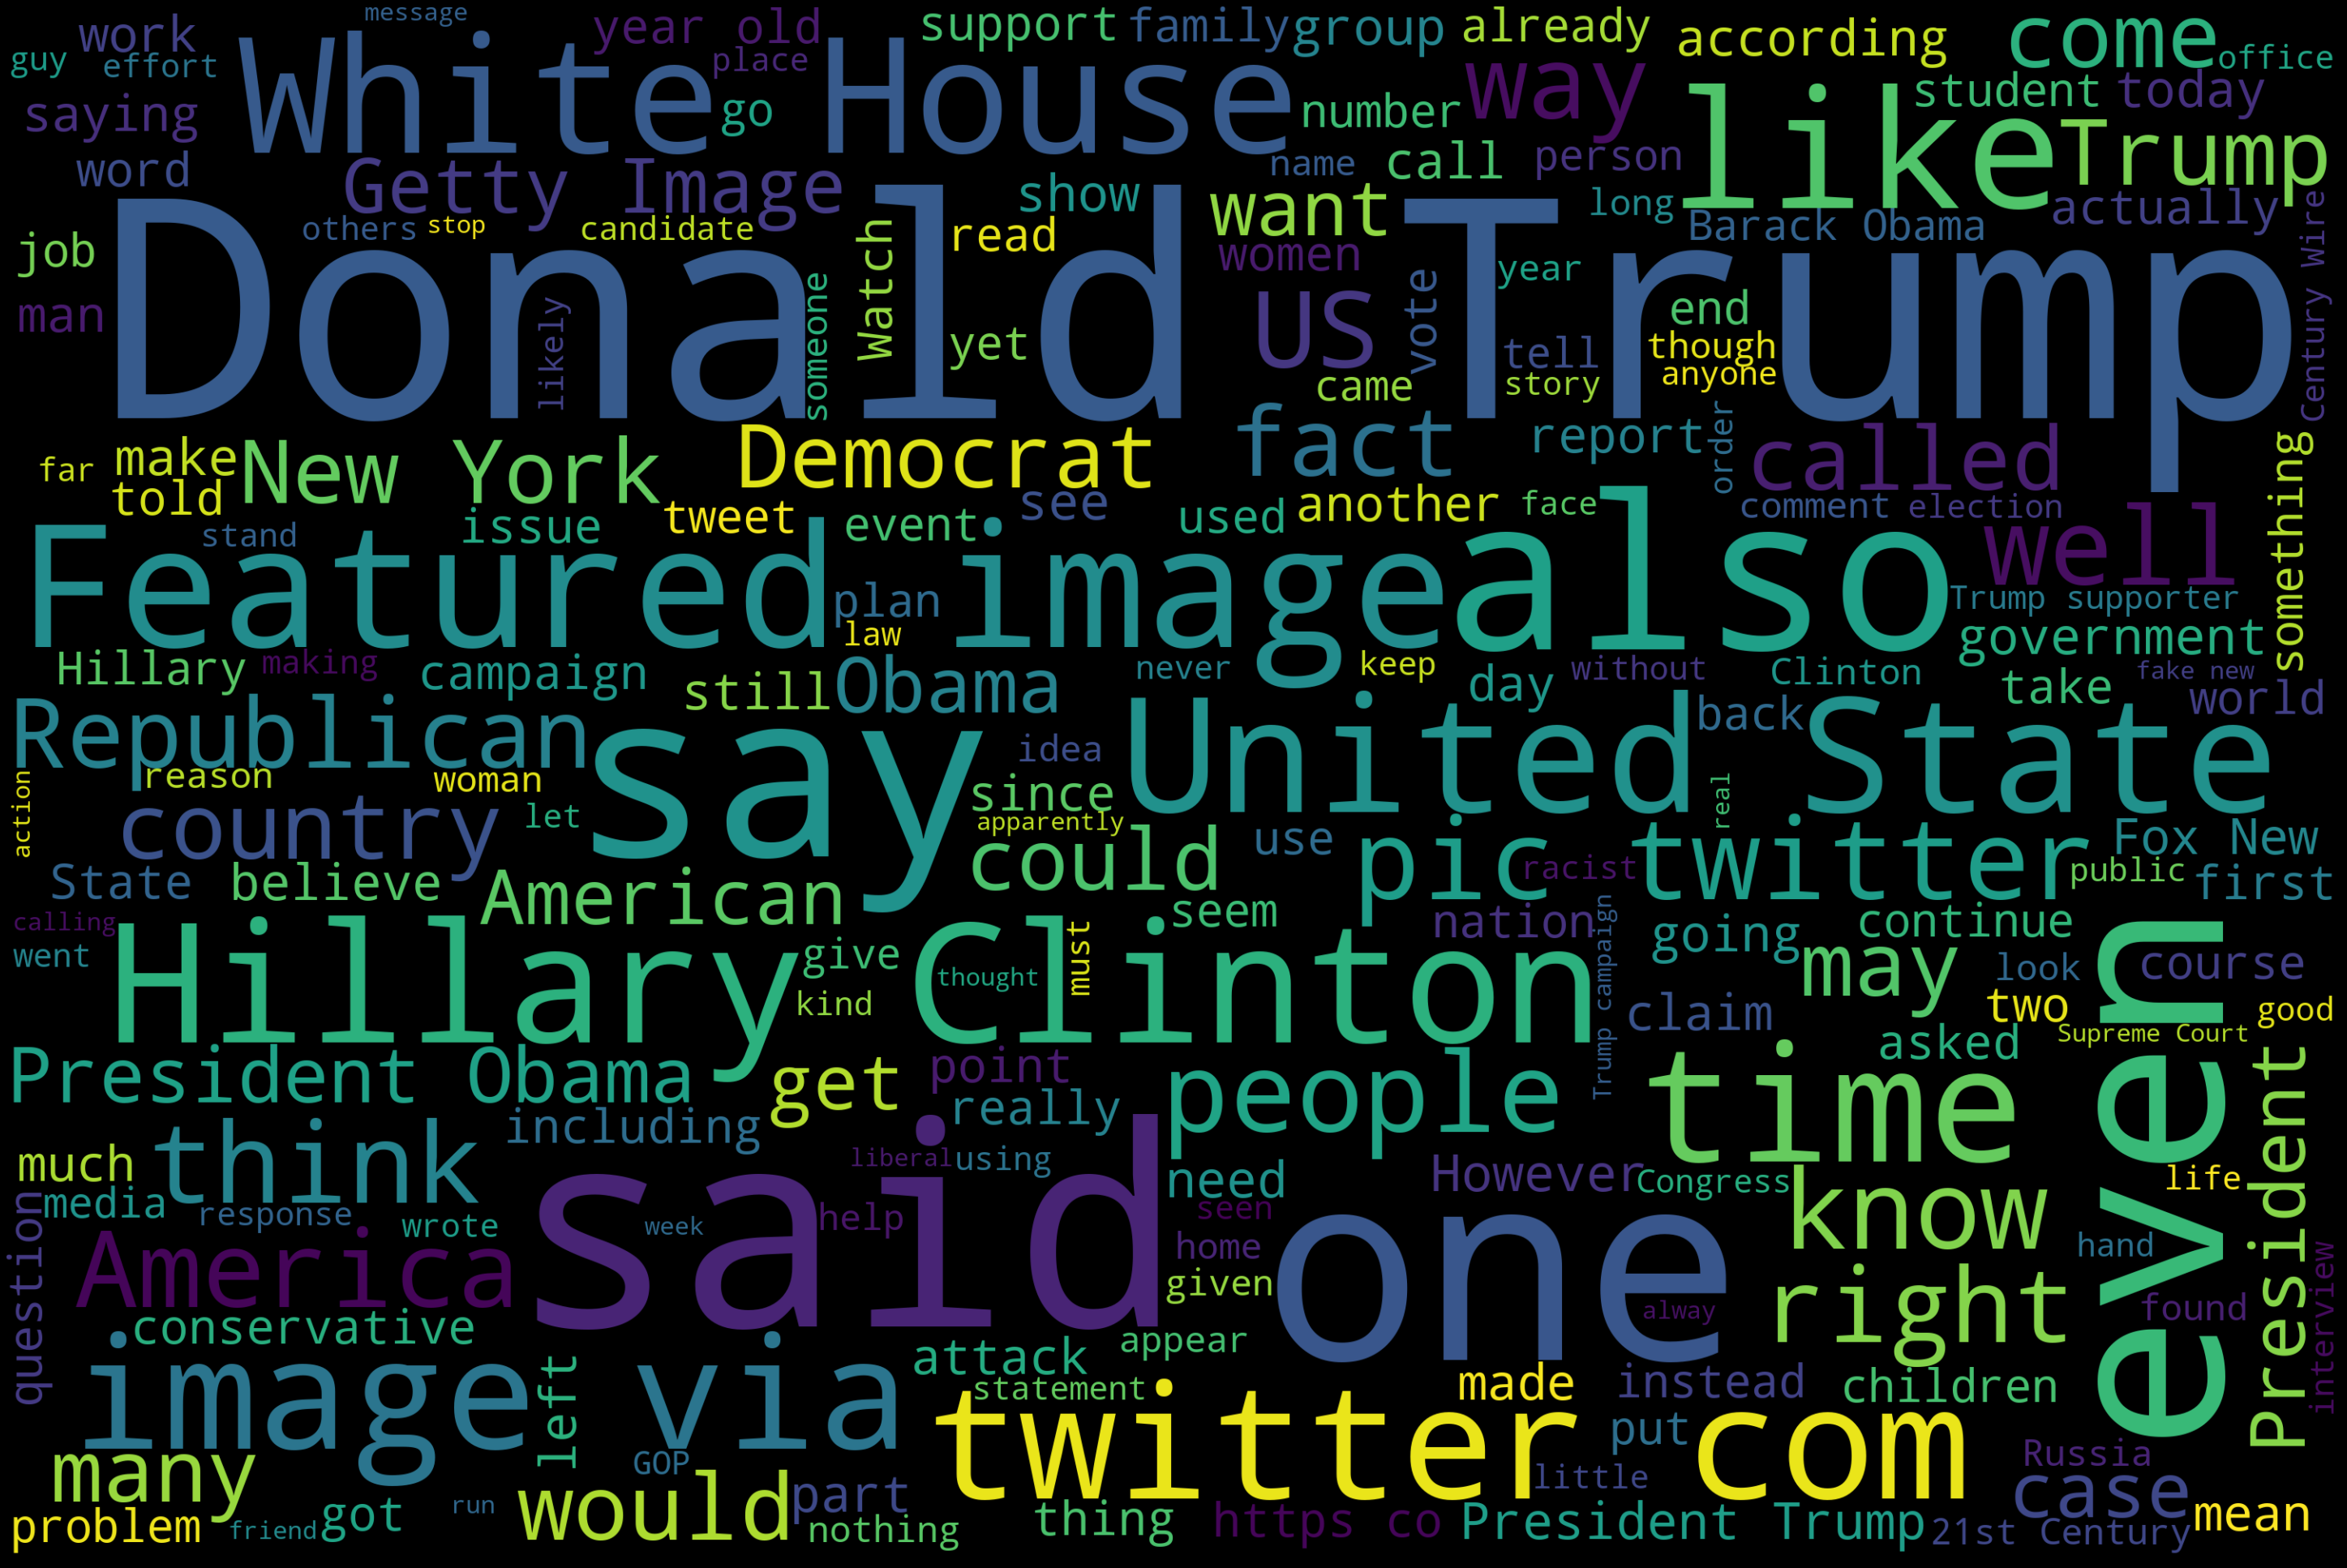

In [10]:
# WordCloud
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(width=3000, height=2000, background_color='black', 
                      stopwords=set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(figsize=(40,30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

## Exploring Real News

In [46]:
real = pd.read_csv('True.csv')
real.tail(20)

title  \
21397  Germany's Schulz says he would demand U.S. wit...   
21398  Blunt instrument? What a list of banned articl...   
21399  Saudi police release teenager detained for dan...   
21400  The People's Princess, Britons work to keep me...   
21401  Argentina labor unions protest job losses, Mac...   
21402  Exclusive: Trump's Afghan decision may increas...   
21403  U.S. puts more pressure on Pakistan to help wi...   
21404  Exclusive: U.S. to withhold up to $290 million...   
21405  Trump talks tough on Pakistan's 'terrorist' ha...   
21406  U.S., North Korea clash at U.N. forum over nuc...   
21407  Mata Pires, owner of embattled Brazil builder ...   
21408  U.S., North Korea clash at U.N. forum over nuc...   
21409  U.S., North Korea clash at U.N. arms forum on ...   
21410  Headless torso could belong to submarine journ...   
21411  North Korea shipments to Syria chemical arms a...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
21397  BERLIN (Reuters) - The leader of Germany s Soc...  worldnews   
21398  SHANGHAI (Reuters) - An old review of an acade...  worldnews   
21399  DUBAI (Reuters) - A 14-year-old boy who was de...  worldnews   
21400  LONDON (Reuters) - Abdul Daoud spilt most of t...  worldnews   
21401  BUENOS AIRES (Reuters) - Argentina s main labo...  worldnews   
21402  ON BOARD A U.S. MILITARY AIRCRAFT (Reuters) - ...  worldnews   
21403  WASHINGTON (Reuters) - The United States sugge...  worldnews   
21404  WASHINGTON (Reuters) - The United States has d...  worldnews   
21405  ISLAMABAD (Reuters) - Outlining a new strategy...  worldnews   
21406  GENEVA (Reuters) - North Korea and the United ...  worldnews   
21407  SAO PAULO (Reuters) - Cesar Mata Pires, the ow...  worldnews   
21408  GENEVA (Reuters) - North Korea and the United ...  worldnews   
21409  GENEVA (Reuters) - North Korea and the United ...  worldnews   
21410  COPENHAGEN (Reuters) - Danish police said on T...  worldnews   
21411  UNITED NATIONS (Reuters) - Two North Korean sh...  worldnews   
21412  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
21413  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
21414  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
21415  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
21416  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                   date  
21397  August 23, 2017   
21398  August 23, 2017   
21399  August 22, 2017   
21400  August 23, 2017   
21401  August 22, 2017   
21402  August 22, 2017   
21403  August 21, 2017   
21404  August 22, 2017   
21405  August 22, 2017   
21406  August 22, 2017   
21407  August 22, 2017   
21408  August 22, 2017   
21409  August 22, 2017   
21410  August 22, 2017   
21411  August 21, 2017   
21412  August 22, 2017   
21413  August 22, 2017   
21414  August 22, 2017   
21415  August 22, 2017   
21416  August 22, 2017

### Difference at glance
 Real news text starts with the source of publication which is not present in fake news set
 
 - most of the text contains reuters information such as "WASHINGTON(reuters)"
 - Some text are tweets from Twitter
 - Few text do not contain any publication info

### Feature Engineering

We will remove Reuters or Twitter Tweet information from the text, and create a feature of publisher

- Text can be splitted only once at "-" which is always present after mentioning source of publication, this gives us publication part and text part.
- if the text part is missing, means the puablication details was not given for that record.
- The Twitter tweets always have same source, a long text of max 259 characters.

In [23]:
# First create a list of index that do not hve publisher part.
unknown_publishers = []
for index,content in enumerate(real.text.values):
    try:
        record = content.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [24]:
#now let's check the list
real.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [26]:
# separating publication info, from actual text
publisher = []
tmp_text = []
for index, content in enumerate(real.text.values):
    if index in unknown_publishers:
        #add unknown of publisher not mentioned
        tmp_text.append(content)
        publisher.append("Unknown")
        continue
    record = content.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [27]:
#replacing existing text column with new text
#add seperate column for publication info
real['publisher']=publisher
real['text']=tmp_text

del publisher, tmp_text, record, unkown_publishers

In [28]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0   The head of a conservative Republican faction...  politicsNews   
1   Transgender people will be allowed for the fi...  politicsNews   
2   The special counsel investigation of links be...  politicsNews   
3   Trump campaign adviser George Papadopoulos to...  politicsNews   
4   President Donald Trump called on the U.S. Pos...  politicsNews   

                 date                     publisher  
0  December 31, 2017           WASHINGTON (Reuters)  
1  December 29, 2017           WASHINGTON (Reuters)  
2  December 31, 2017           WASHINGTON (Reuters)  
3  December 30, 2017           WASHINGTON (Reuters)  
4  December 29, 2017   SEATTLE/WASHINGTON (Reuters)

In [29]:
# check if there's any NA value (empty text)
[index for index, text in enumerate(real.text.values) if str(text).strip() =='']

[8970]

In [30]:
# drop the empty row
real = real.drop(8970, axis=0)

In [32]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"Number of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

Number of empty rows: 630


title text    subject  \
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  
21816  Apr 27, 2015  
21826  Apr 25, 2015  
21827  Apr 25, 2015  
21857  Apr 14, 2015  
21873  Apr 12, 2015

630 Rows in Fake news with empty text

Also noticed fake news have a lot of CPATIAL-CASES. Could preserve Cases of letters, but as we are using Google's pretrained word2vec vectors later on, which haswell-formed lower cases word. We will contert to lower case.

The text for these rows seems to be present in title itself. Lets merge title and text to solve these cases.

In [34]:
# checking if some part of text has been included as publisher info... No such cases fortunately
for name,count in real.publisher.value_counts().iteritems():
    print(f"Name: {name}\nCount: {count}\n")

Name: WASHINGTON (Reuters)
Count: 6389

Name: (Reuters)
Count: 1483

Name: LONDON (Reuters)
Count: 705

Name: NEW YORK (Reuters)
Count: 695

Name: MOSCOW (Reuters)
Count: 623

Name: BERLIN (Reuters)
Count: 499

Name: BEIJING (Reuters)
Count: 433

Name: BRUSSELS (Reuters)
Count: 346

Name: BEIRUT (Reuters)
Count: 346

Name: PARIS (Reuters)
Count: 301

Name: ANKARA (Reuters)
Count: 246

Name: MEXICO CITY (Reuters)
Count: 226

Name: TOKYO (Reuters)
Count: 207

Name: SEOUL (Reuters)
Count: 203

Name: GENEVA (Reuters)
Count: 197

Name: UNITED NATIONS (Reuters)
Count: 184

Name: MADRID (Reuters)
Count: 182

Name: DUBAI (Reuters)
Count: 174

Name: CAIRO (Reuters)
Count: 160

Name: MANILA (Reuters)
Count: 151

Name: HARARE (Reuters)
Count: 140

Name: ISTANBUL (Reuters)
Count: 140

Name: BAGHDAD (Reuters)
Count: 136

Name: CHICAGO (Reuters)
Count: 136

Name: NAIROBI (Reuters)
Count: 125

Name: SYDNEY (Reuters)
Count: 114

Name: JERUSALEM (Reuters)
Count: 107

Name: JOHANNESBURG (Reuters)
Count:

In [35]:
#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

#Counting by Subjects 
for key,count in real.subject.value_counts().iteritems():
  print(f"{key}:\t{count}")

Total Records:	21416
politicsNews:	11271
worldnews:	10145


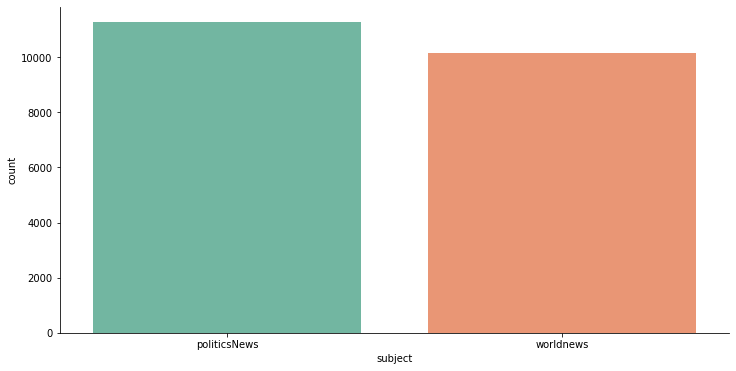

In [39]:
plt.figure(figsize=(12,6))
sns.countplot(x='subject', data=real, palette="Set2")
sns.despine()
plt.show()

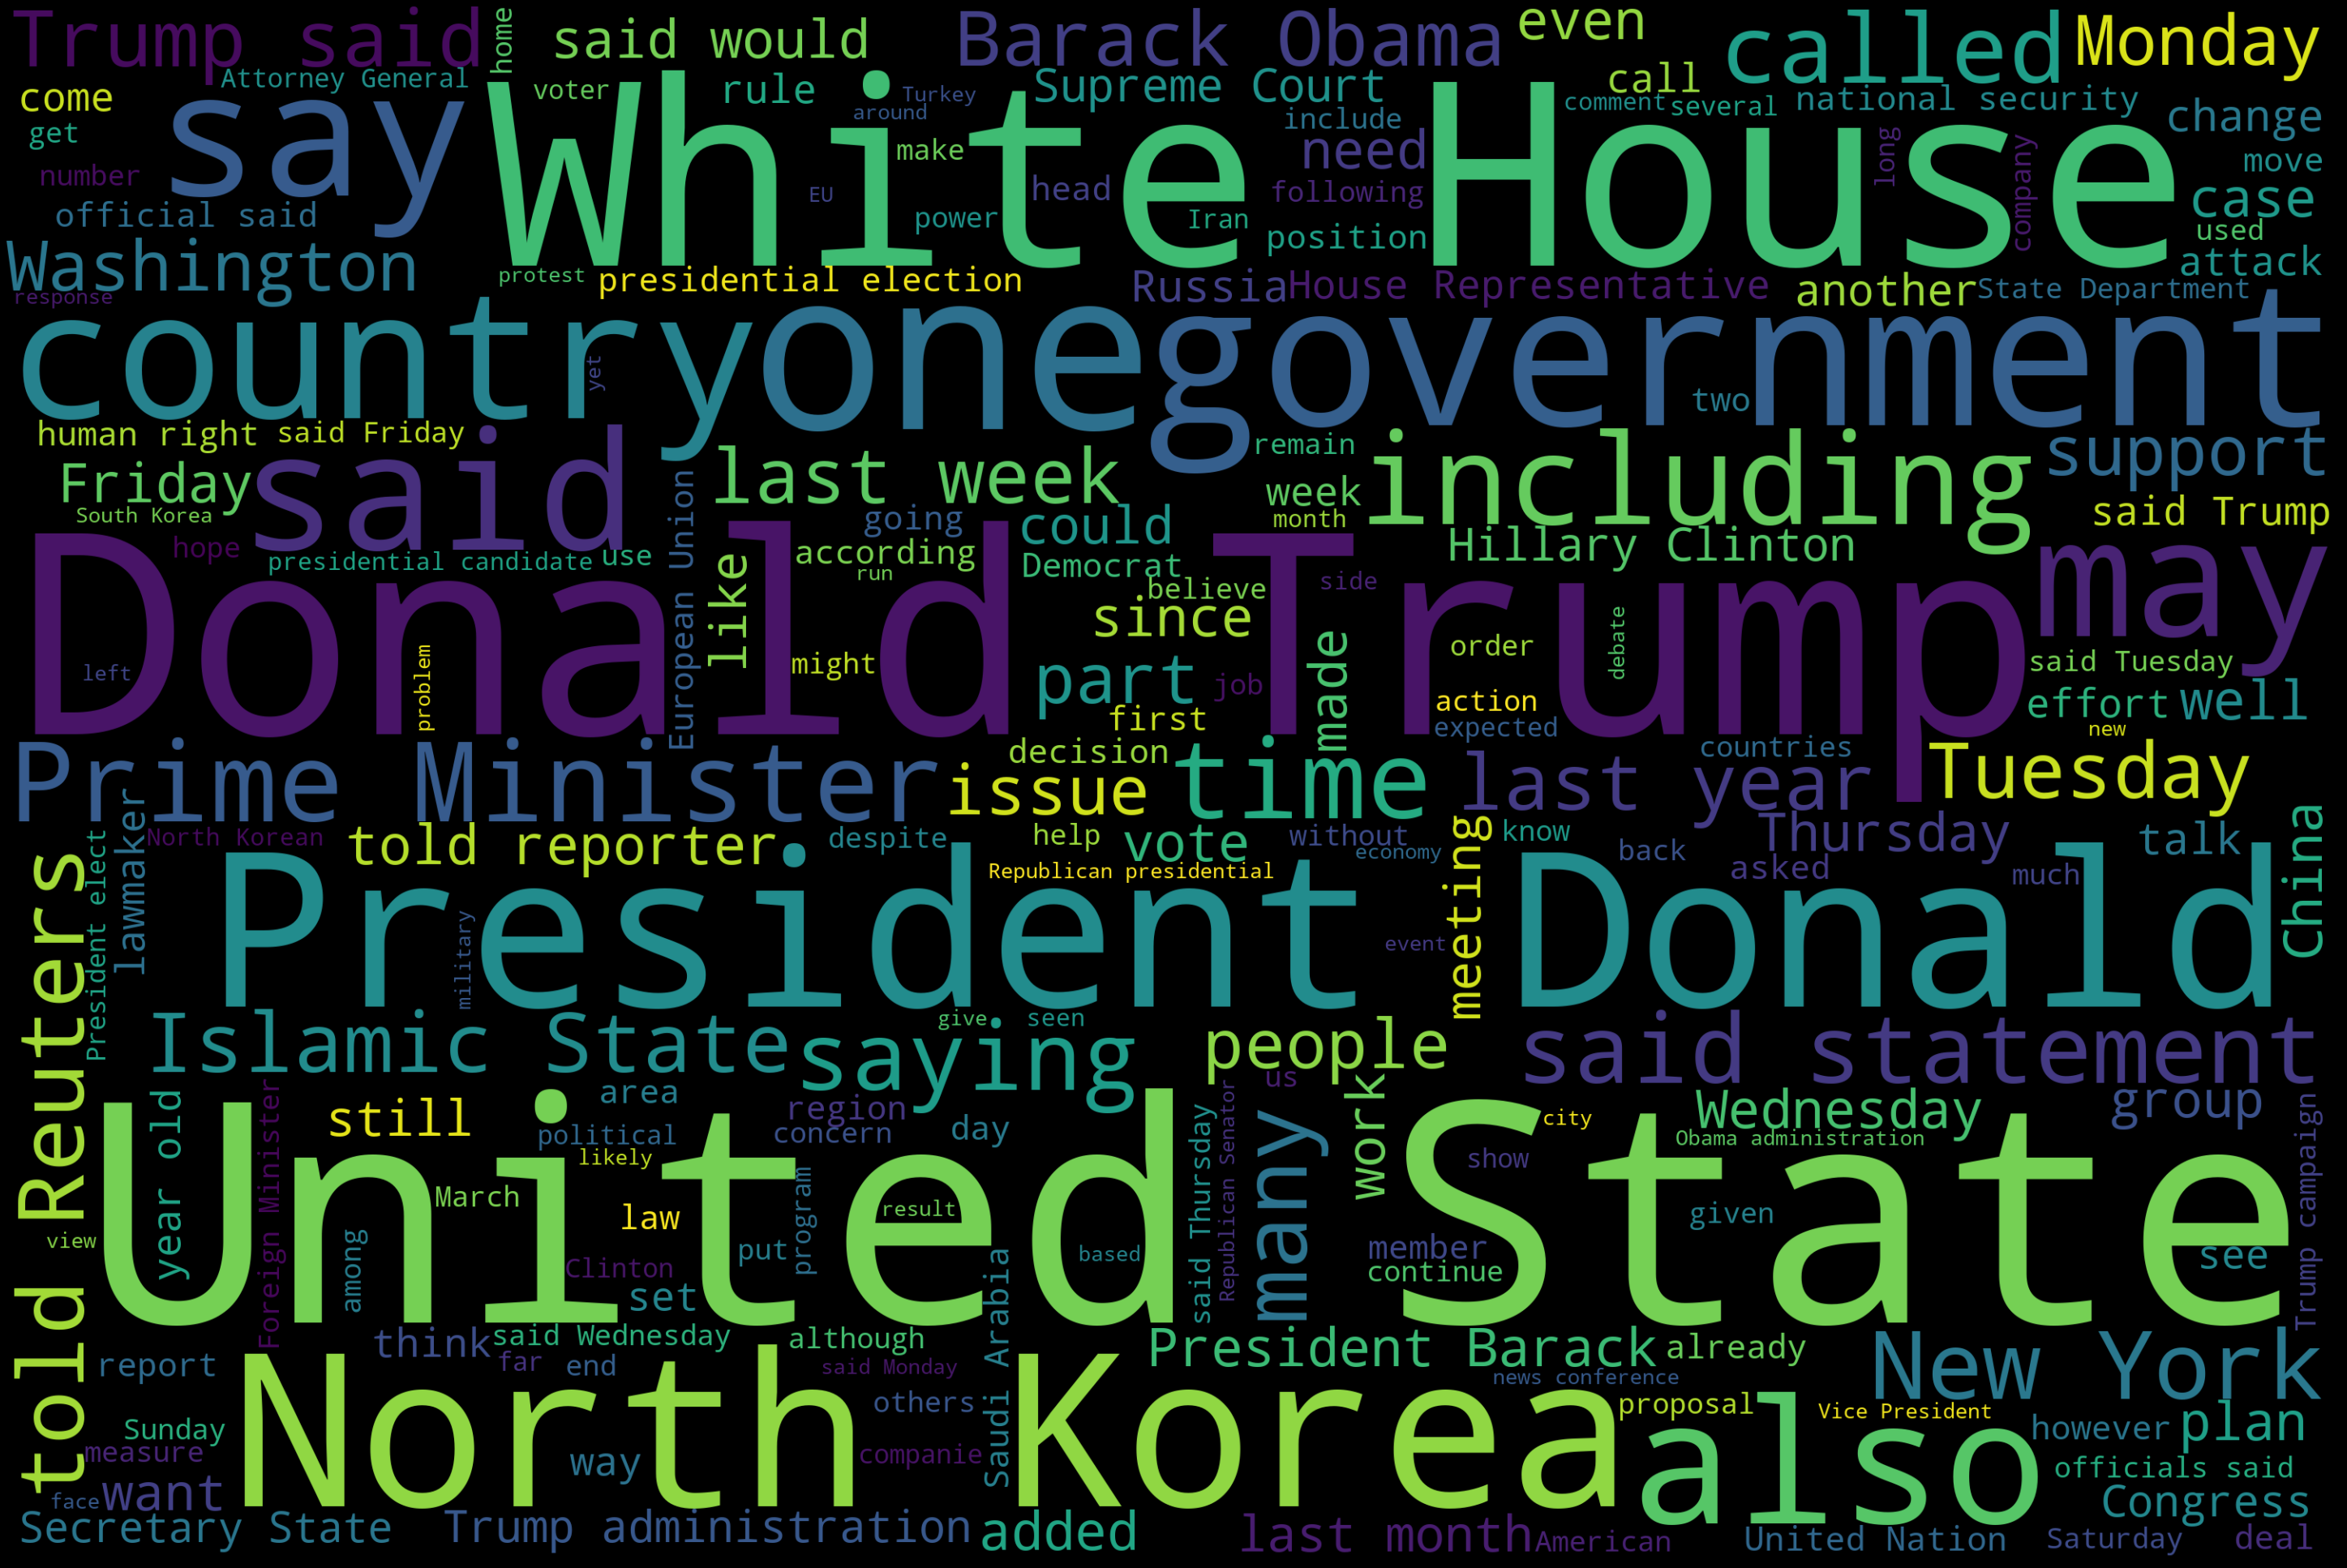

In [40]:
#WordCloud for real news
text = ''
for news in real.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

## Combining Data / Data Cleaning

In [51]:
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf

Using TensorFlow backend.


In [47]:
# adding class information
real["class"] = 1
fake["class"] = 0

In [48]:
# combining title and text
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [49]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
real = real.drop(["subject", "date","title"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [50]:
#Combining both into new dataframe
data = real.append(fake, ignore_index=True)
del real, fake

In [61]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
data['text']=data['text'].apply(denoise_text)

#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

## Vectorization Word2Vec

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

In [55]:
import gensim

In [62]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [63]:
# let's check these vectors
w2v_model.wv.most_similar("china")

[('beijing', 0.7906621694564819),
 ('taiwan', 0.7456915378570557),
 ('chinese', 0.7137594223022461),
 ('india', 0.6580488681793213),
 ('waterway', 0.6518685221672058),
 ('japan', 0.6428727507591248),
 ('xi', 0.6255244016647339),
 ('vietnam', 0.6116156578063965),
 ('sino', 0.5944077968597412),
 ('mainland', 0.5669745802879333)]

In [64]:
w2v_model.wv.most_similar("kushner")

[('jared', 0.7755054235458374),
 ('azxnwgztpv', 0.6389726400375366),
 ('veselnitskaya', 0.6286641359329224),
 ('manafort', 0.584119439125061),
 ('wyand', 0.575160026550293),
 ('jaredwyand', 0.5660197138786316),
 ('flynn', 0.5611687898635864),
 ('sexton', 0.5381367802619934),
 ('ivanka', 0.5364866256713867),
 ('sorhaindo', 0.5351375341415405)]

In [65]:
w2v_model.wv.most_similar("facebook")

[('instagram', 0.6674588918685913),
 ('fb', 0.6484018564224243),
 ('reddit', 0.6323218941688538),
 ('gofundme', 0.6210886240005493),
 ('google', 0.6061517596244812),
 ('online', 0.5939048528671265),
 ('blog', 0.5745705366134644),
 ('ratherour', 0.5708189010620117),
 ('4chan', 0.564724326133728),
 ('charliedarwinsfather', 0.5606709718704224)]

In [66]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])

[('cruz', 0.526407778263092),
 ('incoming', 0.515127420425415),
 ('elect', 0.51320880651474),
 ('bush', 0.5027339458465576),
 ('americas_dad', 0.5008840560913086),
 ('crooked', 0.49997076392173767),
 ('hillary', 0.49452531337738037),
 ('amateur', 0.4705885052680969),
 ('course', 0.46680164337158203),
 ('actually', 0.4586758017539978)]

Looking at the similar words, vectors are well formed for these words :)

In [67]:
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [68]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[391, 394, 10513, 56, 5514, 1285, 4904, 33, 13, 314]

In [69]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


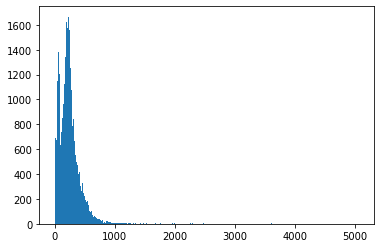

In [70]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

In [71]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43981

In [72]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [73]:
len(X[0])

700

In [74]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [75]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.

Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [76]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

## Training the Model

In [78]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

del embedding_vectors

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 100)          11846400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 700, 128)          117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 700, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

In [80]:
y = data["class"].values

In [81]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [82]:
model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=256)

Instructions for updating:
Use tf.cast instead.
Train on 23571 samples, validate on 10102 samples
Epoch 1/10
23571/23571 [==============================] - 2925s 124ms/step - loss: 0.1931 - acc: 0.9278 - val_loss: 0.0813 - val_acc: 0.9711
Epoch 2/10
23571/23571 [==============================] - 3917s 166ms/step - loss: 0.0862 - acc: 0.9700 - val_loss: 0.0773 - val_acc: 0.9731
Epoch 3/10
23571/23571 [==============================] - 4132s 175ms/step - loss: 0.0453 - acc: 0.9860 - val_loss: 0.0299 - val_acc: 0.9906
Epoch 4/10
23571/23571 [==============================] - 4136s 175ms/step - loss: 0.0291 - acc: 0.9905 - val_loss: 0.0177 - val_acc: 0.9947
Epoch 5/10
23571/23571 [==============================] - 4202s 178ms/step - loss: 0.0182 - acc: 0.9942 - val_loss: 0.0189 - val_acc: 0.9947
Epoch 6/10
23571/23571 [==============================] - 4162s 177ms/step - loss: 0.0111 - acc: 0.9971 - val_loss: 0.0076 - val_acc: 0.9976
Epoch 7/10
23571/23571 [==============================] 

## Model Analysis

In [84]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

33673/33673 [==============================] - 246s 7ms/step
Accuracy of the model on Training Data is -  99.88121046535801
11225/11225 [==============================] - 84s 7ms/step
Accuracy of the model on Testing Data is -  99.84855233853007


In [87]:
pred = model.predict_classes(X_test)
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5784
    Not Fake       1.00      1.00      1.00      5441

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [88]:
cm = confusion_matrix(y_test,pred)
cm

array([[5779,    5],
       [  12, 5429]], dtype=int64)

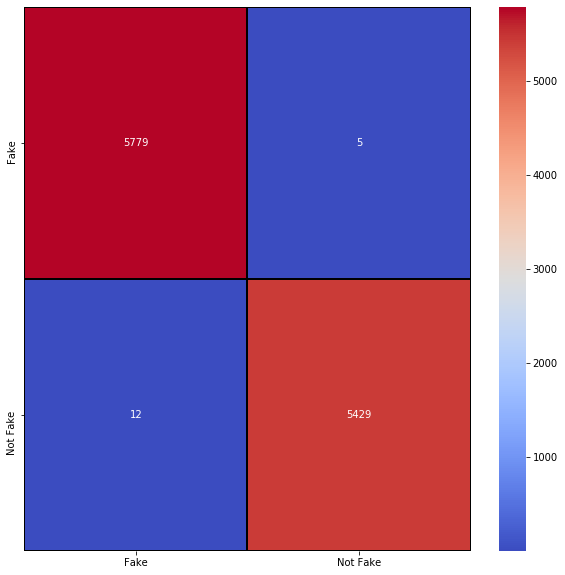

In [90]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Not Fake'] , yticklabels = ['Fake','Not Fake'])
plt.show()